## Exercise 1: Logistic Regression on MNIST

In [ ]:
import sklearn
from sklearn.datasets import load_digits

# import the datasets, look at the shapes
# X is #samples x feature dimensionality
X, y = load_digits(return_X_y=True)
print(X.shape) # Out: (1797, 64) -> 64 is a flattened 8x8 image
print(y.shape) # Out: (1797,)

(1797, 64)
(1797,)


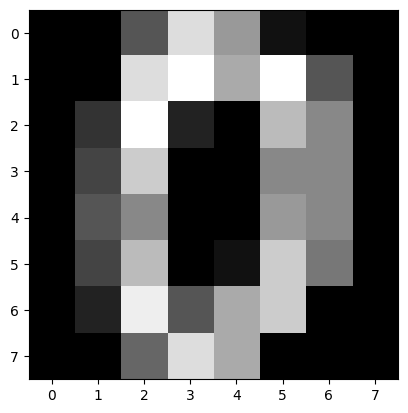

In [ ]:
import matplotlib.pyplot as plt

# reshape a sample as an image and plot it
reshaped_arr = X[0].reshape(8,8)
plt.imshow(reshaped_arr, cmap='gray') # we need to specify via 'cmap' that it's a greyscale image

(array([178., 182., 177., 183., 181., 182., 181., 179., 174., 180.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

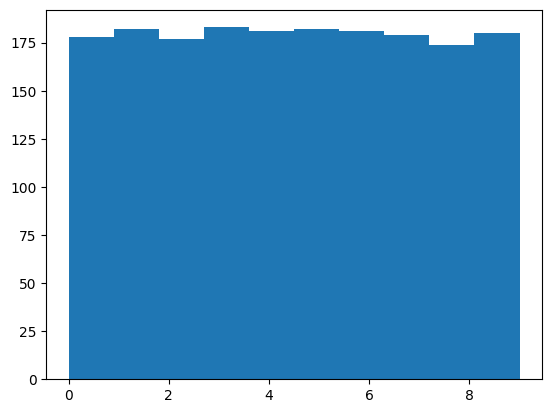

In [ ]:
# histogram of the label distribution
plt.hist(y)

In [ ]:
from sklearn.model_selection import train_test_split

# create a stratified train-test split with 200 samples as a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=42)

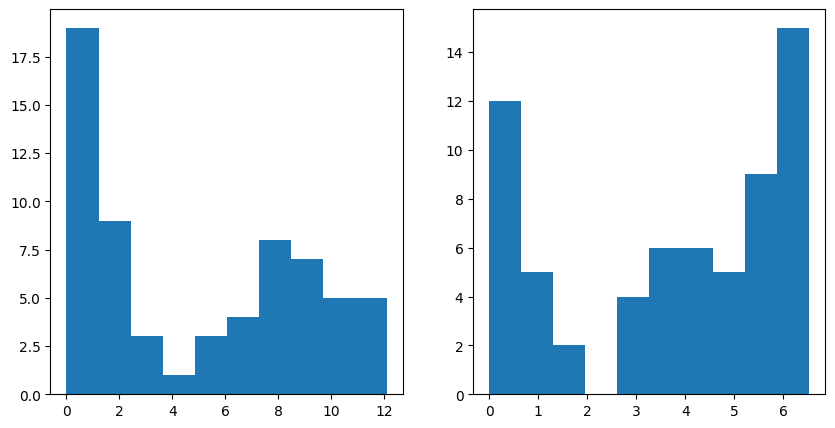

In [ ]:
# plot distribution of mean and std BEFORE standardization
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist(X_train.mean(axis=0))
ax[1].hist(X_train.std(axis=0))
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
# standardize features
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

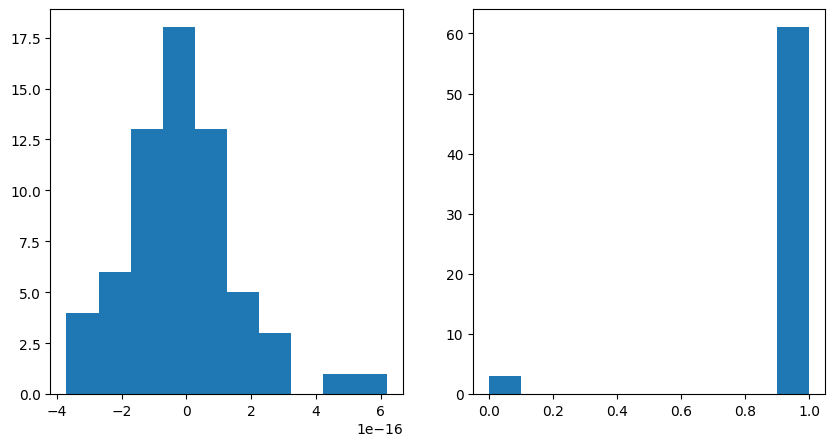

In [ ]:
# plot distribution of mean and std AFTER standardization
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist(X_train.mean(axis=0))
ax[1].hist(X_train.std(axis=0))
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

# train logistic regressor with 1-vs-all scheme to handle the non-binary labels
regressor = LogisticRegression(multi_class='ovr')
regressor.fit(X_train, y_train)
              
acc = regressor.score(X_test, y_test)
print(f'Test set accuracy: {acc}')

Test set accuracy: 0.98


In [ ]:
from sklearn.linear_model import LogisticRegression

# train logistic regressor estimating a multinomial distribution
# to handle the non-binary labels
regressor = LogisticRegression(multi_class='multinomial')
regressor.fit(X_train, y_train)
              
acc = regressor.score(X_test, y_test)
print(f'Test set accuracy: {acc}')

Test set accuracy: 0.98


### Exercise 1.b : apply PCA

In [ ]:
import numpy as np
retain_variances = np.arange(0.5, 1, 0.05)
retain_variances

array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [ ]:
import warnings
# to avoid spawning warnings that the gradient descent did not 
# converge; it's not important
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
from sklearn.decomposition import PCA
# train Logistic Regressor after applying PCA with different
# levels of retained variances

accuracies = [] 
n_comps = []
for retain_var in retain_variances:
    pca = PCA(retain_var) # keep retain_var % variance
    pca.fit(X_train)

    X_pca_train = pca.transform(X_train)
    X_pca_test = pca.transform(X_test)

    regressor = LogisticRegression()
    regressor.fit(X_pca_train, y_train)
    
    n_comps.append(pca.n_components_)
    accuracies.append(regressor.score(X_pca_test, y_test))

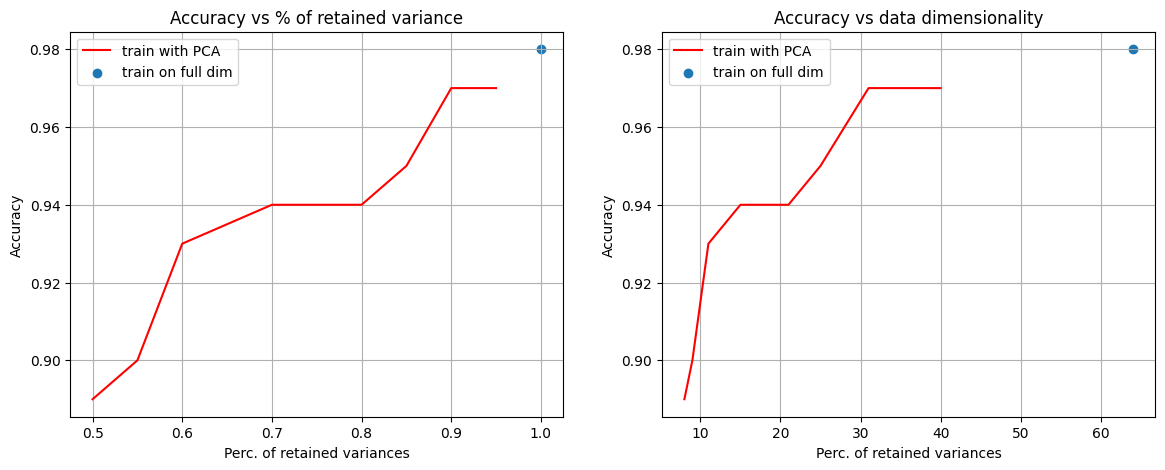

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
# plot the obtained score with increasing portion of explained variance in the data
# the plot on the right reports how many components were actually kept
i = 0
ax[i].set_title('Accuracy vs % of retained variance')
ax[i].plot(retain_variances, accuracies, c='red', label='train with PCA')
ax[i].scatter(1, acc, label='train on full dim')
ax[i].set_xlabel('Perc. of retained variances')
ax[i].set_ylabel('Accuracy')
ax[i].legend()
ax[i].grid()

i = 1
ax[i].set_title('Accuracy vs data dimensionality')
ax[i].plot(n_comps, accuracies, c='red', label='train with PCA')
ax[i].scatter(64, acc, label='train on full dim')
ax[i].set_xlabel('Perc. of retained variances')
ax[i].set_ylabel('Accuracy')
ax[i].legend()
ax[i].grid()

plt.show()

## Exercise 2 : PCA on Fashion-MNIST

In [ ]:
!git clone https://github.com/zalandoresearch/fashion-mnist.git
%cd fashion-mnist

Cloning into 'fashion-mnist'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 762 (delta 0), reused 3 (delta 0), pack-reused 758
Receiving objects: 100% (762/762), 105.85 MiB | 45.09 MiB/s, done.
Resolving deltas: 100% (444/444), done.
/content/fashion-mnist


In [ ]:
from utils import mnist_reader

# load data and inspect shapes
# we don't need the test set
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
# X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
X_train.shape # we have 28x28 flattened images

(60000, 784)

In [ ]:
from sklearn.pipeline import Pipeline

# apply Standardization and PCA, with 85% of explained variance
steps = [('scaling', StandardScaler()), ('pca', PCA(n_components=0.85))]
pipeline = Pipeline(steps)
x_train = pipeline.fit_transform(X_train)
pipeline['pca'].n_components_ # it only takes 81 out of 784 dimensions

81

In [ ]:
# now we take x_train which was mapped to the reduced sub-space,
# and apply the inverse transform. The inverse transform is simply
# a matrix multiplication that maps the data back to the original space.
# Of course this inverse transform will not obtain the original data. The
# 15% variance that was not explained by the PCA is lost
x_train_retransformed = pipeline.inverse_transform(x_train)
x_train.shape, x_train_retransformed.shape

((60000, 81), (60000, 784))

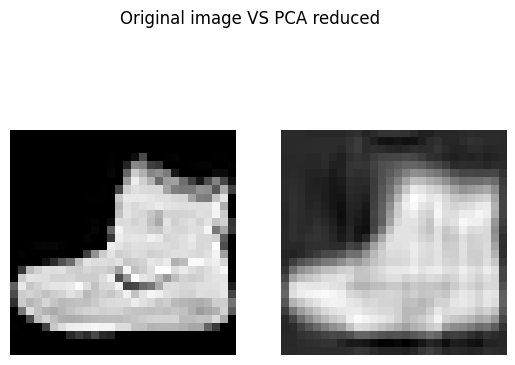

In [ ]:
# now we plot an original sample, and its version obtained with the
# inverse transform

# play with this and try to plot samples from other classes
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.matshow(X_train[0].reshape(28,28), cmap='gray')
ax2.matshow(x_train_retransformed[0].reshape(28,28), cmap='gray')
ax1.set_axis_off()
ax2.set_axis_off()
fig.suptitle("Original image VS PCA reduced".format(y_train[0]))
plt.show()

### Exercise 2.b : First N principal components vs Last N

Now we want to see the difference between using only the first principal components (i.e. the directions that explain most of the variance) versus those that explain the least variance.
Sklearn only allows to map data into the first principal components, so we are going to:
- Fit the PCA estimator asking to return 784 principal components. This number is equal to original dimensionality. In this way we will have access to the reprojection matrix for all the principal components (PCs). Remember that the PCs are eigenvectors of the covariance matrix, and they indicate the directions of maximum variance, ordered from highest to lowest explained variance
- Then we use this estimated PCA to map the data from the original 784-d space into another 784-d space. In this second 784-d space, each dimension represents a PC, with the first being the one that explains the most data. In the code that we used above, we only used the first 81 dimensions of this space.
- Then we are going to take the first 10 PC, and use the reprojection matrix to map samples back in the original space to plot them.
- Then we can do the same by taking the last 10 PC, map them back in the original space, plot them and see the difference

In [ ]:
from sklearn.pipeline import Pipeline

steps = [('scaling', StandardScaler()), ('pca', PCA(n_components=784))]
pipeline = Pipeline(steps)
x_train = pipeline.fit_transform(X_train)
pipeline['pca'].n_components_

784

In [ ]:
n_comp = 10
first_n_comp = pipeline['pca'].components_[:n_comp] # take first 10 PC
last_n_comp = pipeline['pca'].components_[-n_comp:] # take last 10 PC

# here we map the sample with first 10 PC back into the original space by using the
# estimated reprojection matrix. (and summing back the mean)
reconstructed_from_first_comp = np.dot(x_train[:,:n_comp], first_n_comp) + pipeline['pca'].mean_
reconstructed_from_first_comp = pipeline['scaling'].inverse_transform(reconstructed_from_first_comp)   

# here we map the sample with last 10 PC back into the original space by using the
# estimated reprojection matrix. (and summing back the mean)
reconstructed_from_last_comp = np.dot(x_train[:,-n_comp:], last_n_comp) + pipeline['pca'].mean_
reconstructed_from_last_comp = pipeline['scaling'].inverse_transform(reconstructed_from_last_comp) 

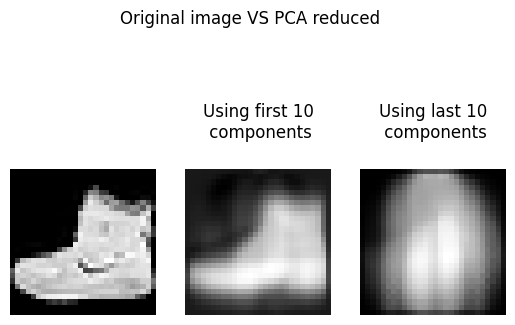

In [ ]:
# look at results
fig, ax = plt.subplots(1, 3)
ax[0].matshow(X_train[0].reshape(28,28), cmap='gray')
ax[1].matshow(reconstructed_from_first_comp[0].reshape(28,28), cmap='gray')
ax[2].matshow(reconstructed_from_last_comp[0].reshape(28,28), cmap='gray')

ax[1].set_title(f'Using first {n_comp}\n components')
ax[2].set_title(f'Using last {n_comp}\n components')
for i in range(3):
    ax[i].set_axis_off()

fig.suptitle("Original image VS PCA reduced")
plt.show()

## Exercise 4: write a Dataset class

In [ ]:
# download the CIFAR-10 dataset and untar it
%cd
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xf cifar-10-python.tar.gz

/root
--2023-04-18 12:50:49--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  91.3MB/s    in 1.8s    

2023-04-18 12:50:52 (91.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
# function to load pickled data from the dataset
def unpickle(data_file):
    import pickle
    with open(data_file, 'rb') as fo:
        data = pickle.load(fo, encoding='latin1')
    return data

#### Exploration phase: understand data format and how to read it in order to write the dataset class

In [ ]:
# read the first batch file and metadata
file_1 = 'cifar-10-batches-py/data_batch_1'
meta_file = 'cifar-10-batches-py/batches.meta'

data_1 = unpickle(file_1)
meta = unpickle(meta_file)

In [ ]:
# meta data files contains label names
meta['label_names']

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
# discover that each batch file is a dictionary, with the following keys
type(data_1), list(data_1.keys())

(dict, ['batch_label', 'labels', 'data', 'filenames'])

In [ ]:
# discover that the 'data' field contains a numpy array with the images
type(data_1['data']), data_1['data'].shape

(numpy.ndarray, (10000, 3072))

In [ ]:
# each array in the matrix is a 32x32 flattened image
3072 / 32 /32 /3

1.0

Class: frog


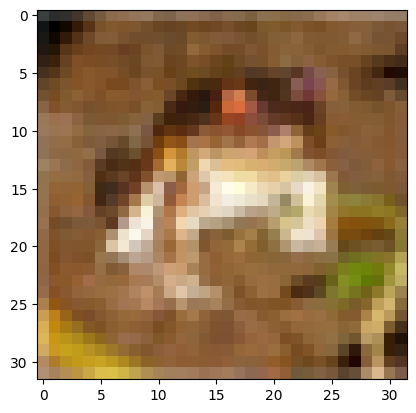

In [ ]:
# plot an image from
image = data_1['data'][0]
label = data_1['labels'][0]
print(f"Class: {meta['label_names'][label]}")

# reshape the flattened array into an image
im = image.reshape(3, 32, 32)
plt.imshow(im.transpose(1, 2, 0)) # matplotlib expects an image to be in the format HxWxC

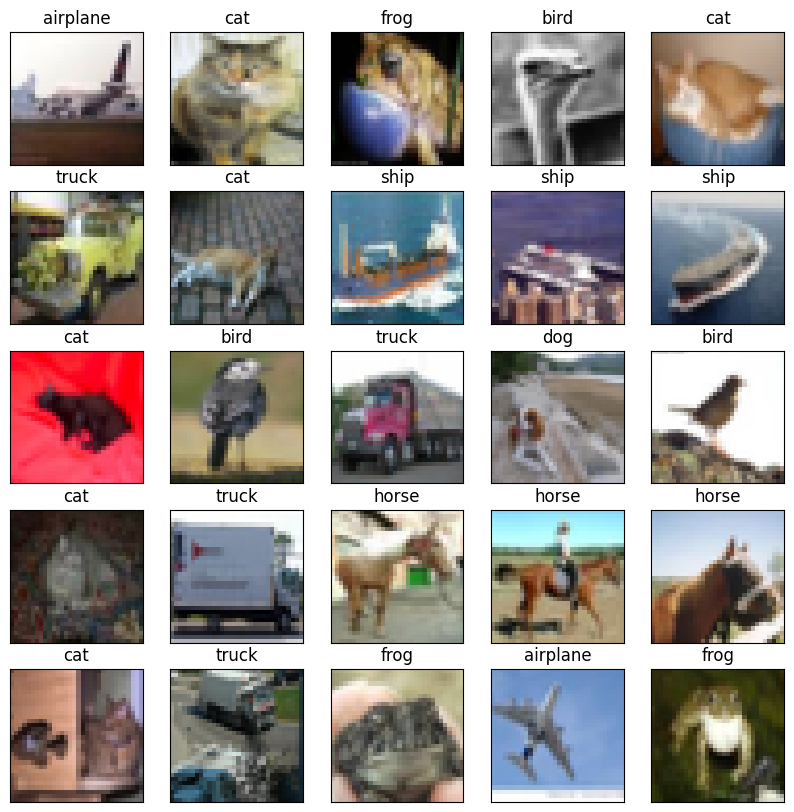

In [ ]:
# take the images data from batch data
images = data_1['data']
# take labels of the images 
labels = data_1['labels']
# label names of the images
label_names = meta['label_names']

# reshape and transpose the images
images = images.reshape(len(images),3,32,32).transpose(0,2,3,1)

# dispaly random images
# define row and column of figure
rows, columns = 5, 5
# take random image idex id
imageId = np.random.randint(0, len(images), rows * columns)
# take images for above random image ids
images = images[imageId]
# take labels for these images only
labels = [labels[i] for i in imageId]

# define figure
fig=plt.figure(figsize=(10, 10))
# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{label_names[labels[i-1]]}")

#### Now we now everything we need to write the dataset class

In [ ]:
from torch.utils.data import Dataset, DataLoader
import pickle
import numpy as np
import os

def unpickle(data_file):
    import pickle
    with open(data_file, 'rb') as fo:
        data = pickle.load(fo, encoding='latin1')
    return data
    
class Cifar10(Dataset):
    def __init__(self, dataset_folder, split='train', transform=None):
        assert split in ['train', 'test'], 'split must be either train or test'
        
        # read paths of batch files and metadata
        if split == 'train':
            batch_files = [file_path for file_path in os.listdir(dataset_folder) if file_path.startswith('data_batch')]
        else:
            batch_files = ['test_batch']

        images = []
        labels = []
        # load images and the labels from the batch files into a list
        for batch in batch_files:
            data = unpickle(os.path.join(dataset_folder, batch))
            batch_images = data['data']
            batch_images = batch_images.reshape(len(batch_images),3,32,32)
            batch_labels = data['labels']

            images.append(batch_images)
            labels += batch_labels

        # stack the images into a single array
        self.images = np.stack(images).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        self.labels = labels
        self.meta = unpickle(os.path.join(dataset_folder, 'batches.meta'))['label_names']
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
import torchvision.transforms as T

dataset_folder = 'cifar-10-batches-py'
transform = T.ToTensor()
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# instantiate the Dataset class
train_ds = Cifar10(dataset_folder, transform=transform)

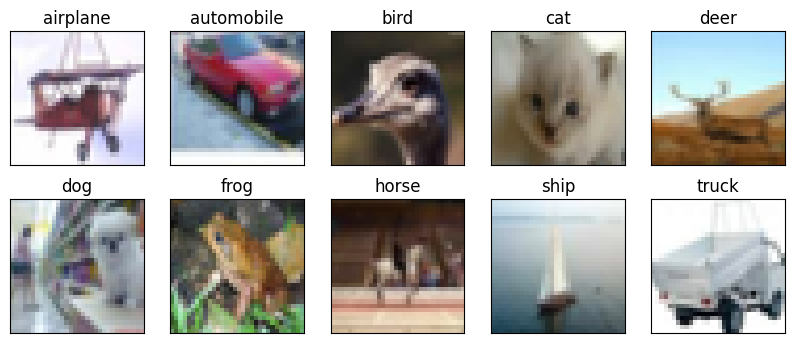

In [ ]:
import random
# find one image per class and plot it

labels = np.arange(0, 10)
np_labels = np.array(train_ds.labels)
image_per_class = []
for lab in labels:
    idx = random.choice(np.where(np_labels == lab)[0])
    image_per_class.append(idx)
rows, columns = 2, 5

# define figure
fig=plt.figure(figsize=(10, 4))
# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_ds.images[image_per_class[i-1]])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{train_ds.meta[labels[i-1]]}")

In [ ]:
batch_size = 16
# declare a dataloader for the train dataset
trainloader = DataLoader(train_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# declare a dataset for the test split and its dataloader
test_ds = Cifar10(dataset_folder, split='test', transform=transform)
testloader = DataLoader(test_ds, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# iterate on the dataset using the dataloader (stop after 10 iterations)
for i, (image, label) in enumerate(trainloader):
    if i > 9:
        break
    print(f'batch n.{i}, batch shape: {image.shape}, labels: {label}')

batch n.0, batch shape: torch.Size([16, 3, 32, 32]), labels: tensor([4, 3, 9, 2, 7, 9, 4, 2, 4, 3, 8, 9, 4, 9, 4, 7])
batch n.1, batch shape: torch.Size([16, 3, 32, 32]), labels: tensor([2, 6, 0, 4, 7, 2, 2, 0, 7, 5, 8, 0, 9, 4, 2, 7])
batch n.2, batch shape: torch.Size([16, 3, 32, 32]), labels: tensor([3, 1, 5, 4, 5, 7, 8, 8, 8, 1, 3, 2, 0, 1, 4, 9])
batch n.3, batch shape: torch.Size([16, 3, 32, 32]), labels: tensor([0, 6, 8, 5, 2, 4, 6, 2, 0, 6, 4, 0, 2, 8, 3, 3])
batch n.4, batch shape: torch.Size([16, 3, 32, 32]), labels: tensor([7, 8, 0, 9, 9, 8, 3, 2, 0, 6, 3, 1, 9, 2, 5, 8])
batch n.5, batch shape: torch.Size([16, 3, 32, 32]), labels: tensor([5, 2, 0, 1, 9, 3, 1, 8, 8, 7, 9, 0, 1, 0, 4, 8])
batch n.6, batch shape: torch.Size([16, 3, 32, 32]), labels: tensor([7, 2, 3, 3, 8, 9, 4, 4, 0, 0, 9, 4, 5, 6, 6, 3])
batch n.7, batch shape: torch.Size([16, 3, 32, 32]), labels: tensor([2, 2, 4, 0, 9, 5, 6, 2, 1, 5, 6, 8, 7, 6, 6, 0])
batch n.8, batch shape: torch.Size([16, 3, 32, 32]), lab

## Exercise 5: Classification on CIFAR-10

The code below is copied from the tutorial whose link you find in the slides.
The only part I modified is in the beginning where we use the dataset class that we just wrote above. We do not expect you to fully understand this code, you can completely ignore this part if it just gives you an headache.

You can just run it (it will take a while), see what it prints out, if you want you can try to read it and start to undertand what it does. Your project will have a training loop likely very similar to this one. Anyway as the course goes on you will receive all the information you need to understand this


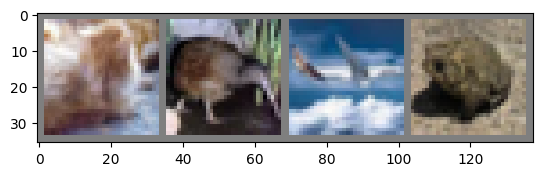

cat   bird  plane frog 
[1,  2000] loss: 2.178
[1,  4000] loss: 1.846
[1,  6000] loss: 1.686
[1,  8000] loss: 1.575
[1, 10000] loss: 1.460
[1, 12000] loss: 1.398
[2,  2000] loss: 1.271
[2,  4000] loss: 1.217
[2,  6000] loss: 1.171
[2,  8000] loss: 1.133
[2, 10000] loss: 1.083
[2, 12000] loss: 1.079
Finished Training


In [ ]:
from torch.nn.modules.linear import init

import torch
import torchvision
import torchvision.transforms as transforms


batch_size = 4
################ USE OUR DATASETS #################################
trainset = train_ds
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = test_ds
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
##################################################################

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

########################################################################
# Let us show some of the training images, for fun.

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

########################################################################
# 2. Define a Convolutional Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Copy the neural network from the Neural Networks section before and modify it to
# take 3-channel images (instead of 1-channel images as it was defined).

import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.autograd import Variable



# Define a Convolutional Neural Network
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net().cuda() 

__all__ = ['ResNet', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        #不能简单的增加网络深度 会导致梯度弥散或梯度爆炸。gradient dispersion or gradient explosion
        #batch normalization解决
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])


def resnet56():
    return ResNet(BasicBlock, [9, 9, 9])

########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim
net=resnet56()

criterion = nn.CrossEntropyLoss() #loss function
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#learning rate is 0.001
########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize.



for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        torch.cuda.is_available()
        device='cuda:0'
        net=net.to(device)
        outputs = net(inputs)
        labels=labels.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

########################################################################
# Let's quickly save our trained model:

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

########################################################################
# See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
# for more details on saving PyTorch models.
#


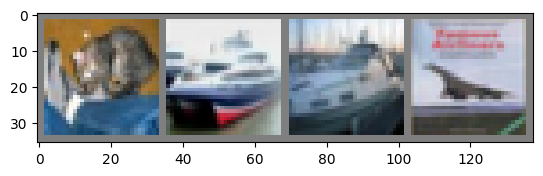

GroundTruth:  cat   ship  ship  plane
Predicted:  dog   ship  truck plane
Accuracy of the network on the 10000 test images: 62 %
Accuracy for class: plane is 71.6 %
Accuracy for class: car   is 76.4 %
Accuracy for class: bird  is 62.6 %
Accuracy for class: cat   is 13.4 %
Accuracy for class: deer  is 40.8 %
Accuracy for class: dog   is 69.7 %
Accuracy for class: frog  is 75.4 %
Accuracy for class: horse is 74.1 %
Accuracy for class: ship  is 59.2 %
Accuracy for class: truck is 81.5 %
cuda:0


In [ ]:
# 5. TTTTTTTTTTest the network on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# We have trained the network for 2 passes over the training dataset.
# But we need to check if the network has learnt anything at all.
#
# We will check this by predicting the class label that the neural network
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

########################################################################
# Next, let's load back in our saved model (note: saving and re-loading the model
# wasn't necessary here, we only did it to illustrate how to do so):


net.load_state_dict(torch.load(PATH))

########################################################################
# Okay, now let us see what the neural network thinks these examples above are:

images = images.to(device)
outputs = net(images)
outputs = outputs.to(device)


########################################################################
# The outputs are energies for the 10 classes.
# The higher the energy for a class, the more the network
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

########################################################################
# The results seem pretty good.
#
# Let us look at how the network performs on the whole dataset.

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        device='cuda:0'
        images, labels = data
        images=images.to(device)
        labels=labels.to(device)
        # calculate outputs by running images through the network
        
        net=net.to(device)
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

#######################EX6 add

########################################################################
# That looks way better than chance, which is 10% accuracy (randomly picking
# a class out of 10 classes).
# Seems like the network learnt something.
#
# Hmmm, what are the classes that performed well, and the classes that did
# not perform well:

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        device='cuda:0'
        torch.cuda.is_available()
        net=net.to(device)
       
        images=images.to(device)
        labels=labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

########################################################################
# Okay, so what next?
#
# How do we run these neural networks on the GPU?
#
# Training on GPU
# ----------------
# Just like how you transfer a Tensor onto the GPU, you transfer the neural
# net onto the GPU.
#
# Let's first define our device as the first visible cuda device if we have
# CUDA available:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net=net.to(device)

########################################################################
# The rest of this section assumes that ``device`` is a CUDA device.
#
# Then these methods will recursively go over all modules and convert their
# parameters and buffers to CUDA tensors:
#
# .. code:: python
#
#     net.to(device)
#
#
# Remember that you will have to send the inputs and targets at every step
# to the GPU too:
#
# .. code:: python
#
#         inputs, labels = data[0].to(device), data[1].to(device)
#
# Why don't I notice MASSIVE speedup compared to CPU? Because your network
# is really small.
#
# **Exercise:** Try increasing the width of your network (argument 2 of
# the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
# they need to be the same number), see what kind of speedup you get.
#
# **Goals achieved**:
#
# - Understanding PyTorch's Tensor library and neural networks at a high level.
# - Train a small neural network to classify images
#
# Training on multiple GPUs
# -------------------------
# If you want to see even more MASSIVE speedup using all of your GPUs,
# please check out :doc:`data_parallel_tutorial`.
#
# Where do I go next?
# -------------------
#
# -  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
# -  `Train a state-of-the-art ResNet network on imagenet`_
# -  `Train a face generator using Generative Adversarial Networks`_
# -  `Train a word-level language model using Recurrent LSTM networks`_
# -  `More examples`_
# -  `More tutorials`_
# -  `Discuss PyTorch on the Forums`_
# -  `Chat with other users on Slack`_
#
# .. _Train a state-of-the-art ResNet network on imagenet: https://github.com/pytorch/examples/tree/master/imagenet
# .. _Train a face generator using Generative Adversarial Networks: https://github.com/pytorch/examples/tree/master/dcgan
# .. _Train a word-level language model using Recurrent LSTM networks: https://github.com/pytorch/examples/tree/master/word_language_model
# .. _More examples: https://github.com/pytorch/examples
# .. _More tutorials: https://github.com/pytorch/tutorials
# .. _Discuss PyTorch on the Forums: https://discuss.pytorch.org/
# .. _Chat with other users on Slack: https://pytorch.slack.com/messages/beginner/

# %%%%%%INVISIBLE_CODE_BLOCK%%%%%%
del dataiter
# %%%%%%INVISIBLE_CODE_BLOCK%%%%%%